# Imports

In [57]:
import pandas as pd

import re
import random

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy

In [58]:
df = pd.read_csv("QueryResults.csv")

# First exploration and processing

## First sight

In [59]:
df.head()

,Id,CreationDate,Body,Title,Tags
0,39999988,2016-10-12 13:32:02,<p>I'm trying to use Java's Hibernate @Filter ...,Hibernate @Filter entity by @ManyToOne field,<java><hibernate><filter><field><many-to-one>
1,39999984,2016-10-12 13:31:59,<p>I have an image called graph.jpg in the dra...,How can you change the content of a drawable i...,<java><android><image><bitmap><retrofit>
2,39999927,2016-10-12 13:29:33,<p>Configure script fails when checking for C ...,C compiler not found when build openjdk,<build><compiler-errors><configure><java><buil...
3,39999883,2016-10-12 13:28:08,<p>I have a data file which is a result of num...,plot 3D spherical parametric surface using non...,<python><plot><3d><surface><non-uniform-distri...
4,39999882,2016-10-12 13:28:07,<p>It's possible to have something like this.<...,NSManagedObject like Generic object,<ios><swift><generics><core-data><swift3>


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            50000 non-null  int64 
 1   CreationDate  50000 non-null  object
 2   Body          50000 non-null  object
 3   Title         50000 non-null  object
 4   Tags          50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [61]:
df.drop("Id", axis=1, inplace=True)

## Droping duplicates

In [62]:
df.drop_duplicates(subset=['Body'], inplace =True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49998 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CreationDate  49998 non-null  object
 1   Body          49998 non-null  object
 2   Title         49998 non-null  object
 3   Tags          49998 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


## Dates

In [64]:
print("Oldest question:", df.CreationDate.min(), "\nMost recent question:", df.CreationDate.max())

Oldest question: 2016-07-24 12:50:43 
Most recent question: 2016-10-12 13:32:02


In [65]:
df.drop("CreationDate", axis=1, inplace=True)

## Body and title

In [66]:
print("Title:", df.iloc[0].Title, "\n\nBody:", df.iloc[0].Body)

Title: Hibernate @Filter entity by @ManyToOne field 

Body: <p>I'm trying to use Java's Hibernate @Filter on a many to one relationship field, but when I enable the filter and try to call a getAll method using the StockDailyRecord Service from an AJAX I get this:</p>

<pre><code>HTTP Status 500 - Request processing failed; 
nested exception is javax.persistence.PersistenceException:
org.hibernate.exception.SQLGrammarException: could not extract ResultSet
</code></pre>

<p>This is my entity where I define the filter:</p>

<pre><code>@Entity
@Table(name = "stock_daily_record", catalog = "mkyong")
@FilterDef(name="stockDailyRecordFilter")
@Filters({
    @Filter(name="stockDailyRecordFilter", condition="stock.name = 'My stock'"),
})
public class StockDailyRecord extends Entity implements Serializable {
         ...
    @ManyToOne
    @JoinColumn(name = "stock_id", referencedColumnName = "id", nullable = false )
    public Stock getStock() {
        return this.stock;
    }
}
</code></pre>


In [67]:
df["text"] = df["Title"] + df["Body"]
df.drop(columns=["Title", "Body"], inplace=True)

In [68]:
df.head()

,Tags,text
0,<java><hibernate><filter><field><many-to-one>,Hibernate @Filter entity by @ManyToOne field<p...
1,<java><android><image><bitmap><retrofit>,How can you change the content of a drawable i...
2,<build><compiler-errors><configure><java><buil...,C compiler not found when build openjdk<p>Conf...
3,<python><plot><3d><surface><non-uniform-distri...,plot 3D spherical parametric surface using non...
4,<ios><swift><generics><core-data><swift3>,NSManagedObject like Generic object<p>It's pos...


## Tags

In [69]:
df["tags"] = df["Tags"].apply(lambda x: x[1:-1].split("><"))
df.drop("Tags", axis=1, inplace=True)

In [70]:
df.head()

,text,tags
0,Hibernate @Filter entity by @ManyToOne field<p...,"[java, hibernate, filter, field, many-to-one]"
1,How can you change the content of a drawable i...,"[java, android, image, bitmap, retrofit]"
2,C compiler not found when build openjdk<p>Conf...,"[build, compiler-errors, configure, java, buil..."
3,plot 3D spherical parametric surface using non...,"[python, plot, 3d, surface, non-uniform-distri..."
4,NSManagedObject like Generic object<p>It's pos...,"[ios, swift, generics, core-data, swift3]"


In [71]:
dict(pd.Series(l_tags).value_counts())

{'python': 4182,
 'java': 3618,
 'ios': 3389,
 'c#': 3344,
 'php': 2387,
 'android': 2288,
 'javascript': 1852,
 'html': 333,
 'jquery': 274,
 'css': 248}

<AxesSubplot:title={'center':'Tag distribution'}, xlabel='Tags', ylabel='Count'>

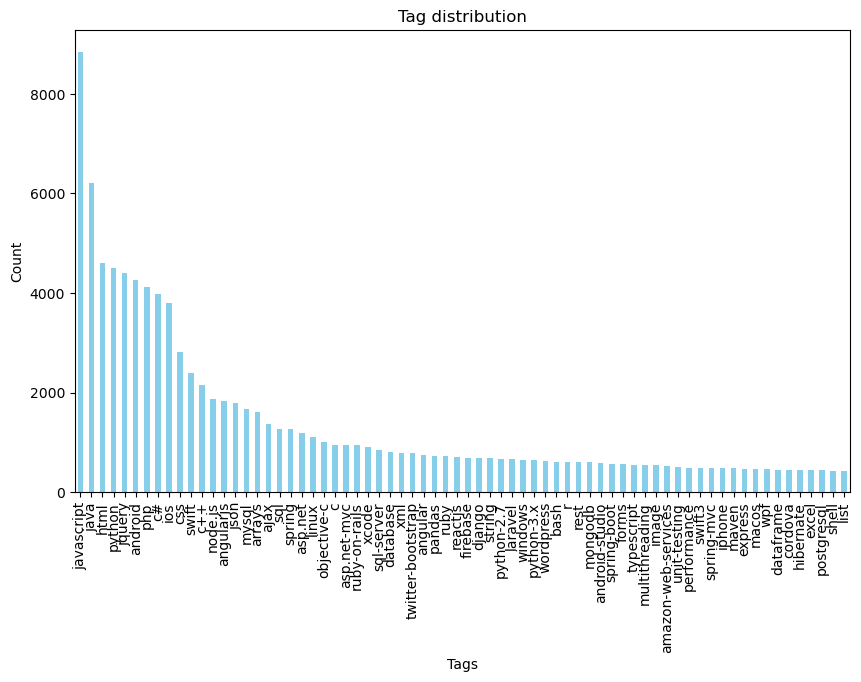

In [72]:
l_tags = []
for tags in df["tags"]:
    l_tags += tags

plt.figure(figsize=(12, 6))
plt.xlabel("Tags")
plt.ylabel("Count")
plt.title("Tag distribution")
pd.Series(l_tags).value_counts().head(70).plot(kind='bar', figsize=(10, 6), color='skyblue')

Deleting rare tags and rebalancing the dataset

In [73]:

most_frequent_tags = pd.Series(l_tags).value_counts().head(10)
l_most_frequent_tags = list(most_frequent_tags.keys())

copy_df = pd.DataFrame()

for tag, occurrences in most_frequent_tags.items():

    df_tag = df.loc[df.tags.apply(lambda x: (set(x) & set(l_most_frequent_tags) == {tag}) and (random.random() < 1/10 * len(df)/occurrences)), :]
    
    copy_df = pd.concat([copy_df, df_tag])

copy_df["tags"] = copy_df["tags"].apply(lambda x: list(set(x) & set(l_most_frequent_tags)))

<AxesSubplot:>

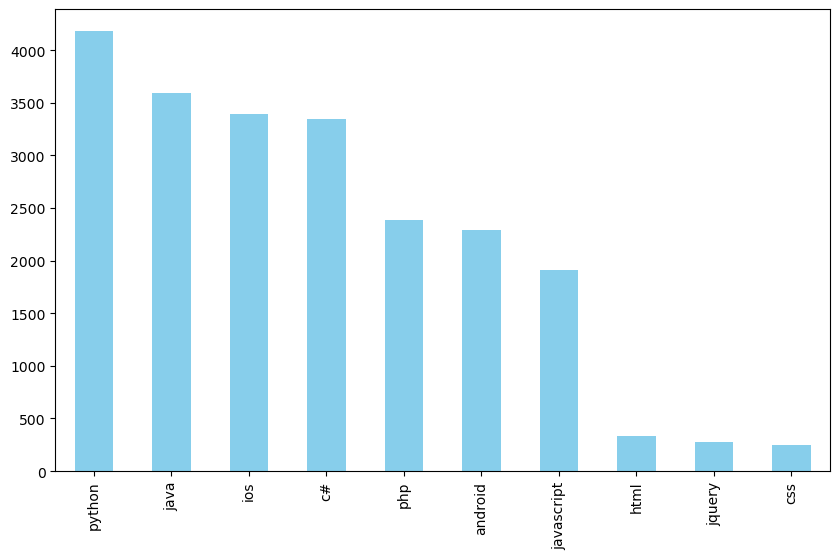

In [74]:
l_tags = []
for tags in copy_df["tags"]:
    l_tags += tags
pd.Series(l_tags).value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')

In [75]:
df = copy_df

# Cleaning the text

In [76]:
stopwords.words("english")

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

## First attempts

In [77]:
def first_cleaning(text):

    text = BeautifulSoup(text).get_text()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    
    words = text.split()
    set_stopwords = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in set_stopwords]   

    return( " ".join(meaningful_words))   

In [78]:
df.iloc[0].tags

['javascript']

In [79]:
df.text[0]

'Hibernate @Filter entity by @ManyToOne field<p>I\'m trying to use Java\'s Hibernate @Filter on a many to one relationship field, but when I enable the filter and try to call a getAll method using the StockDailyRecord Service from an AJAX I get this:</p>\n\n<pre><code>HTTP Status 500 - Request processing failed; \nnested exception is javax.persistence.PersistenceException:\norg.hibernate.exception.SQLGrammarException: could not extract ResultSet\n</code></pre>\n\n<p>This is my entity where I define the filter:</p>\n\n<pre><code>@Entity\n@Table(name = "stock_daily_record", catalog = "mkyong")\n@FilterDef(name="stockDailyRecordFilter")\n@Filters({\n    @Filter(name="stockDailyRecordFilter", condition="stock.name = \'My stock\'"),\n})\npublic class StockDailyRecord extends Entity implements Serializable {\n         ...\n    @ManyToOne\n    @JoinColumn(name = "stock_id", referencedColumnName = "id", nullable = false )\n    public Stock getStock() {\n        return this.stock;\n    }\n}\n</

In [80]:
test = first_cleaning(df.text[0])
test

'hibernate filter entity manytoone fieldi trying use java hibernate filter many one relationship field enable filter try call getall method using stockdailyrecord service ajax get http status request processing failed nested exception javax persistence persistenceexception org hibernate exception sqlgrammarexception could extract resultset entity define filter entity table name stock daily record catalog mkyong filterdef name stockdailyrecordfilter filters filter name stockdailyrecordfilter condition stock name stock public class stockdailyrecord extends entity implements serializable manytoone joincolumn name stock id referencedcolumnname id nullable false public stock getstock return stock however change filter actual column database stock id compare id want filter works without exceptions filter name stockdailyrecordfilter condition stock id enable filter stockdailyrecordservice session hsession getsession isanonymous hsession enablefilter stockdailyrecordfilter else hsession disabl

In [81]:
ps = PorterStemmer()

# and stem the tokens
stems   = [ps.stem(tk) for tk in test.split(" ") ]
print(stems)

['hibern', 'filter', 'entiti', 'manytoon', 'fieldi', 'tri', 'use', 'java', 'hibern', 'filter', 'mani', 'one', 'relationship', 'field', 'enabl', 'filter', 'tri', 'call', 'getal', 'method', 'use', 'stockdailyrecord', 'servic', 'ajax', 'get', 'http', 'statu', 'request', 'process', 'fail', 'nest', 'except', 'javax', 'persist', 'persistenceexcept', 'org', 'hibern', 'except', 'sqlgrammarexcept', 'could', 'extract', 'resultset', 'entiti', 'defin', 'filter', 'entiti', 'tabl', 'name', 'stock', 'daili', 'record', 'catalog', 'mkyong', 'filterdef', 'name', 'stockdailyrecordfilt', 'filter', 'filter', 'name', 'stockdailyrecordfilt', 'condit', 'stock', 'name', 'stock', 'public', 'class', 'stockdailyrecord', 'extend', 'entiti', 'implement', 'serializ', 'manytoon', 'joincolumn', 'name', 'stock', 'id', 'referencedcolumnnam', 'id', 'nullabl', 'fals', 'public', 'stock', 'getstock', 'return', 'stock', 'howev', 'chang', 'filter', 'actual', 'column', 'databas', 'stock', 'id', 'compar', 'id', 'want', 'filter'

In [82]:
! python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [83]:
nlp = spacy.load("en_core_web_sm")
text = BeautifulSoup(df.text[0]).get_text()
text = re.sub("[^a-zA-Z]", " ", text)
doc = nlp(text)

print("token.lemma_")
for token in doc:
    print(token, token.lemma_)
   #print(token, token.is_space, token.is_punct, token.is_upper, token.is_digit, token.is_stop)
#   print(f"{token.text}\t {token.pos_} ")


token.lemma_
Hibernate Hibernate
   
Filter Filter
entity entity
by by
   
ManyToOne ManyToOne
fieldI fieldI
m m
trying try
to to
use use
Java Java
s s
Hibernate Hibernate
   
Filter Filter
on on
a a
many many
to to
one one
relationship relationship
field field
   
but but
when when
I I
enable enable
the the
filter filter
and and
try try
to to
call call
a a
getAll getall
method method
using use
the the
StockDailyRecord StockDailyRecord
Service Service
from from
an an
AJAX AJAX
I I
get get
this this
   
HTTP HTTP
Status Status
             
Request request
processing processing
failed fail
     
nested nest
exception exception
is be
javax javax
persistence persistence
PersistenceException PersistenceException
   
org org
hibernate hibernate
exception exception
SQLGrammarException sqlgrammarexception
   
could could
not not
extract extract
ResultSet ResultSet
   
This this
is be
my my
entity entity
where where
I I
define define
the the
filter filter
     
Entity Entity
   
Table Table
na

## Final attempt

In [84]:
nlp = spacy.load("en_core_web_sm")

def cleaning(text):
    set_stopwords = set(stopwords.words("english"))

    text = BeautifulSoup(text).get_text()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    
    doc = nlp(text)
    meaningful_words = [w.lemma_ for w in doc if not str(w) in set_stopwords]   

    return( " ".join(meaningful_words)) 

In [85]:
cleaning(df.text[0])

'hibernate   filter entity   manytoone fieldi try use java hibernate   filter many one relationship field   enable filter try call getall method use stockdailyrecord service ajax get   http status        request processing fail    nest exception javax persistence persistenceexception   org hibernate exception sqlgrammarexception   could extract resultset   entity define filter    entity   table name     stock daily record    catalog     mkyong     filterdef name   stockdailyrecordfilter     filter         filter name   stockdailyrecordfilter    condition   stock name     stock         public class stockdailyrecord extend entity implement serializable                      manytoone       joincolumn name     stock    referencedcolumnname        nullable    false        public stock getstock              return stock            however change filter actual column database   stock   compare want filter work without exception    filter name   stockdailyrecordfilter    condition   stock     

## Comparison

In [86]:
first_cleaning(df.text[0])

'hibernate filter entity manytoone fieldi trying use java hibernate filter many one relationship field enable filter try call getall method using stockdailyrecord service ajax get http status request processing failed nested exception javax persistence persistenceexception org hibernate exception sqlgrammarexception could extract resultset entity define filter entity table name stock daily record catalog mkyong filterdef name stockdailyrecordfilter filters filter name stockdailyrecordfilter condition stock name stock public class stockdailyrecord extends entity implements serializable manytoone joincolumn name stock id referencedcolumnname id nullable false public stock getstock return stock however change filter actual column database stock id compare id want filter works without exceptions filter name stockdailyrecordfilter condition stock id enable filter stockdailyrecordservice session hsession getsession isanonymous hsession enablefilter stockdailyrecordfilter else hsession disabl

In [87]:
cleaning(df.text[0])

'hibernate   filter entity   manytoone fieldi try use java hibernate   filter many one relationship field   enable filter try call getall method use stockdailyrecord service ajax get   http status        request processing fail    nest exception javax persistence persistenceexception   org hibernate exception sqlgrammarexception   could extract resultset   entity define filter    entity   table name     stock daily record    catalog     mkyong     filterdef name   stockdailyrecordfilter     filter         filter name   stockdailyrecordfilter    condition   stock name     stock         public class stockdailyrecord extend entity implement serializable                      manytoone       joincolumn name     stock    referencedcolumnname        nullable    false        public stock getstock              return stock            however change filter actual column database   stock   compare want filter work without exception    filter name   stockdailyrecordfilter    condition   stock     

## Cleaning the dataset

In [ ]:
df["text"] = df["text"].apply(cleaning)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a8c51f4ce20>>
Traceback (most recent call last):
  File "/home/omar-oc/anaconda3/envs/env_OC_P5_ter/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


# Saving the final dataset

In [ ]:
df

,text,tags
8,protractor break loopi need help loop beak c...,[javascript]
25,electron proxy url create small server out...,[javascript]
41,angular materializecss modal dialog open...,[javascript]
46,throw new typeerror app use require middl...,[javascript]
72,display waiter resolve datum angular pr...,[javascript]
...,...,...
48500,react sass webpack local styling issuei use us...,[css]
48561,blur image default reveal hover like embed i...,[css]
48965,remove label carrier need shipping page presta...,[css]
49580,less add unwanted code url compile cssso somet...,[css]


In [ ]:
df.to_csv("final_dataset.csv")